## This notebook contains examples for building a 2D probe and computing the scalar pressure field for single-frequency (narrow band) and pulsed (broad band) transmits

In [62]:
import numpy as np
import sys
import matplotlib.pyplot as plt

sys.path.append('../') #add pyRayleighCuda to path
import transducers


#display options for the notebook
import matplotlib as mpl

mpl.rcParams['image.cmap'] = 'magma'
mpl.rcParams['image.interpolation'] = 'none'

%matplotlib inline

## Create linear probe

In [ ]:
pitch = 0.2 #mm

#transducer element positions
NN = 128 #number of elements
ux = np.linspace(-NN/2, NN/2, NN)*pitch

uxyz = np.zeros([NN,3])
uxyz[:,0] = ux

#element normals are z-directed
unormals = np.zeros([NN,3])
unormals[:,2] = 1

## Define reconstruction grid

In [247]:
#simulation grid
dx = 0.1
dz = 0.1
xp = np.arange(-16, 16+dx, dx)
yp = [0.0]
zp = np.arange(1.0, 30.0+dz, dz)

Nx,Ny,Nz = (len(xp), len(yp), len(zp))

imgBounds = [zp[0],zp[-1], xp[-1],xp[0]] 
imgBoundsT= np.flipud(imgBounds)
len(zp), len(xp)

(291, 321)

# Narrow-band (single-frequency) transmit

### Calculates $P(\omega) \propto \sum \limits_{n} \frac{e^{i k |\bf{r - u}_n| }}{|\bf{r - u}_n|}$, for $k = \omega / c$

#### Plane wave, narrow band 

In [518]:
c0 = 1480
f0 = 3e6
kr_mm = (2*np.pi*f0/c0)*1e-3 #wavenumber in millimeters

uamp = np.ones([NN], dtype=np.complex)

pr = transducers.calc_pressure_field(kr_mm, uxyz, uamp, xp, yp, zp, unormals=unormals)

pr = pr.squeeze() #remove the singleton y dimension

#### Plot the results:

A narrow-band transmit is equivalent to continous wave so the magnitude of computed of pressure gives a scalar field representing the beam's spatial envelope.

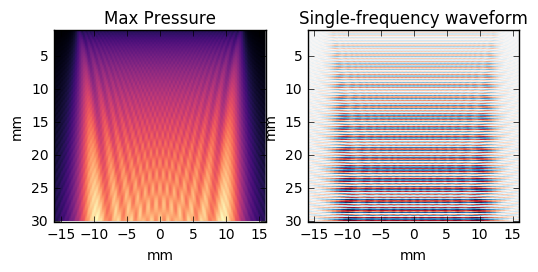

In [521]:

plt.subplot(121)
plt.imshow(np.abs(pr).T, extent=imgBoundsT )
plt.xlabel('mm')
plt.ylabel('mm')
plt.title('Max Pressure')

plt.subplot(122)
plt.imshow(np.real(pr).T, extent=imgBoundsT, cmap=plt.cm.RdBu )
plt.title('Single-frequency waveform')
plt.xlabel('mm')
plt.ylabel('mm')

#### Focused transmit, narrow band

In [126]:
foci_xyz = [[10.0, 0.0, 25.0]]
uamp = transducers.get_focused_element_vals(kr_mm, uxyz, foci_xyz, [1])

pr = transducers.calc_pressure_field(kr_mm, uxyz, uamp, xp, yp, zp, unormals=unormals)

pr = pr.squeeze() #remove the singleton y dimension

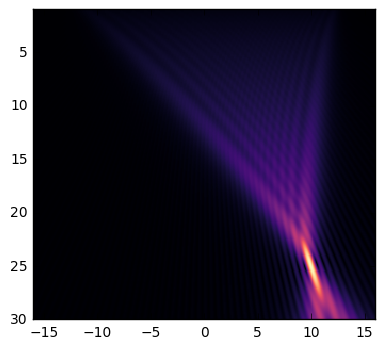

In [127]:
plt.imshow(np.abs(pr).T, extent=imgBoundsT )

#### Multi-focus transmit, narrow band

In [128]:
foci_xyz = [[3.0, 0.0, 20.0], [-3.0, 0.0, 20.0]]
foci_val = np.ones(len(foci_xyz))
uamp = transducers.get_focused_element_vals(kr_mm, uxyz, foci_xyz, foci_val)

pr = transducers.calc_pressure_field(kr_mm, uxyz, uamp, xp, yp, zp, unormals=unormals)

pr = pr.squeeze() #remove the singleton y dimension

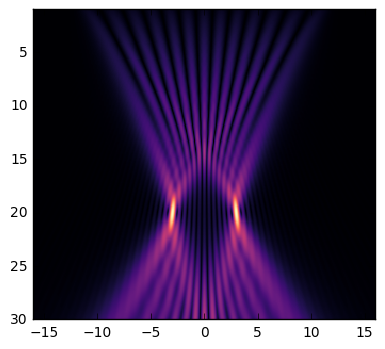

In [129]:
plt.imshow(np.abs(pr).T, extent=imgBoundsT )

#### Alternating phase of foci

In [130]:
uamp = transducers.get_focused_element_vals(kr_mm, uxyz, foci_xyz, foci_val, AlternatePhases=True)

pr = transducers.calc_pressure_field(kr_mm, uxyz, uamp, xp, yp, zp, unormals=unormals)

pr = pr.squeeze() #remove the singleton y dimension

(25, 15)

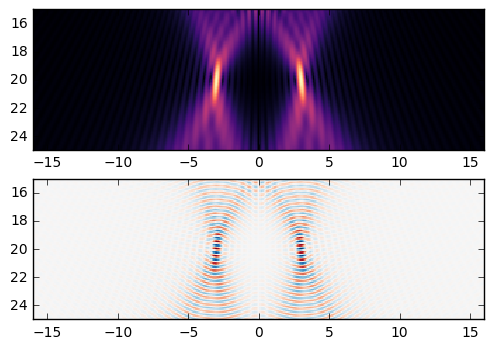

In [131]:
#plt.figure(figsize=(8,4))
plt.subplot(211)
plt.imshow(np.abs(pr).T, extent=imgBoundsT )
plt.ylim([25,15])
plt.subplot(212)
plt.imshow(np.real(pr).T, extent=imgBoundsT, cmap=plt.cm.RdBu )
#plt.xlim()
plt.ylim([25,15])

# Broad-band transmit

Broadband transmits are more difficult since pressure is computed in the Fourier domain. Below is an example of using the spectrum of a gaussian pulse to build a broad-band transmit from a series of narrow band transmits. This is useful to examine the spatial distribution of peak pressure acheived during a pulse, but has limited utility for simulating an actual waveform.

In [174]:
import scipy.signal as sig

In [501]:
fc = 3e6

Fs = 40e6
dt=1/Fs
t_us = np.arange(0.0, 4.0, dt*1e6)
Nt = len(t_us)
mid = round(Nt/2)

w = sig.gausspulse(t_us - t_us[mid], fc=fc*1e-6, bw=0.3)
wfft = np.fft.fft(w)
freqs = np.fft.fftfreq(Nt,d=dt)

df = freqs[1]-freqs[0]

#wfft = np.fft.fftshift(wfft)
#freqs = np.fft.fftshift(freqs)

C:\Users\vchaplin\Anaconda3\lib\site-packages\scipy\signal\waveforms.py:236: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if t == 'cutoff':  # compute cut_off point


In [522]:
#Build broad-band transmit by interpolating several encodings around the center frequency

spec_fr = freqs[0:mid]
spec_envelope = np.abs(wfft[0:mid])

sampling_freqs = np.arange(1e6,5e6,150e3)
nf = len(sampling_freqs)

sampling_envelope = np.zeros(nf)

for i in range(nf):
    fi = sampling_freqs[i]
    sampling_envelope[i] = np.interp(fi, spec_fr, spec_envelope )


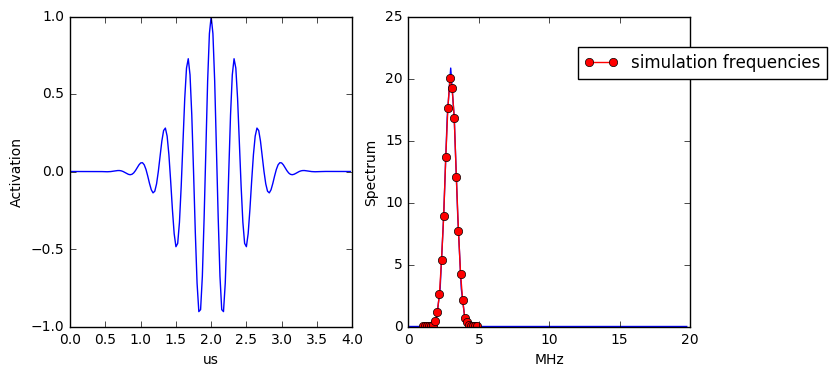

In [523]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(t_us,w)
plt.xlabel('us')
plt.ylabel('Activation')


plt.subplot(122)
plt.plot(freqs[0:mid]*1e-6, np.abs(wfft[0:mid]),'-')
plt.plot(sampling_freqs*1e-6, sampling_envelope, 'ro-', label='simulation frequencies')
plt.xlabel('MHz')
plt.ylabel('Spectrum')
plt.legend(loc=(.6,0.8))

In [525]:

pr = np.zeros([nf,Nx,Ny,Nz],dtype=np.complex)

for i in range(nf):
    uamp = np.ones(NN)*sampling_envelope[i]
    ki_mm = (2*np.pi*sampling_freqs[i]/c0)*1e-3  #wavenumber corresponding to this frequency
    pr[i] = transducers.calc_pressure_field(ki_mm, uxyz, uamp, xp, yp, zp, unormals=unormals)
    
pr = pr.squeeze()

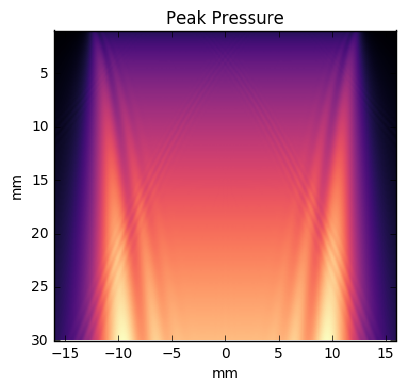

In [526]:
plt.imshow(np.sum( np.abs(pr[0:]), axis=0).T, extent=imgBoundsT )
plt.title('Peak Pressure')
plt.xlabel('mm')
plt.ylabel('mm')

### Time-domain waveforms are repeated due to finite sampling of the input spectral peak:

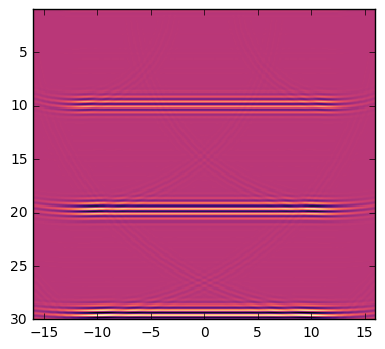

In [527]:
plt.imshow(np.sum(np.real(pr[:]),axis=0).T, extent=imgBoundsT )

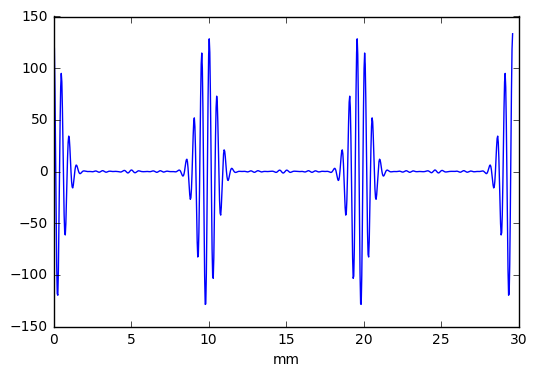

In [528]:
tt = np.arange(0.0,20.0, dt*1e6)
ss=np.zeros_like(tt)
for i in range(nf):
    fi=2*np.pi*sampling_freqs[i]*1e-6
    ss+= sampling_envelope[i]*np.cos(fi*(tt)) 
    
plt.plot(tt*c0*1e-3, ss)
plt.xlabel('mm')

In [542]:
pr = np.zeros([nf,Nx,Ny,Nz],dtype=np.complex)

uamp = transducers.get_focused_element_vals(2*np.pi*fc/c0*1e-3, uxyz, [[5,0,15]], [1], L1renorm=NN)

for i in range(nf):
    uamp_i = uamp*sampling_envelope[i]
    ki_mm = (2*np.pi*sampling_freqs[i]/c0)*1e-3  #wavenumber corresponding to this frequency
    pr[i] = transducers.calc_pressure_field(ki_mm, uxyz, uamp_i, xp, yp, zp, unormals=unormals)
    
pr = pr.squeeze()

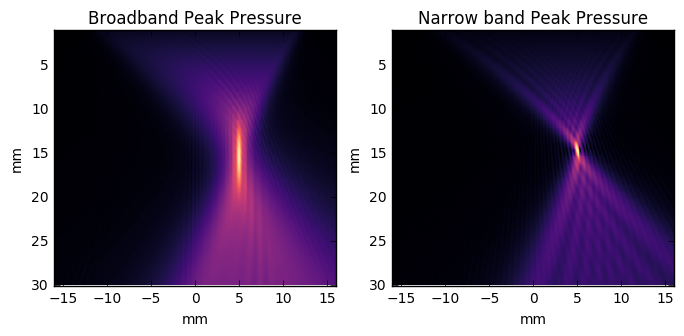

In [543]:
fi = np.argmin(np.abs(sampling_freqs-fc))

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(np.sum( np.abs(pr[0:]), axis=0).T, extent=imgBoundsT )
plt.title('Broadband Peak Pressure')
plt.xlabel('mm')
plt.ylabel('mm')

plt.subplot(122)
plt.imshow( np.abs(pr[fi]).T, extent=imgBoundsT )
plt.title('Narrow band Peak Pressure')
plt.xlabel('mm')
plt.ylabel('mm')

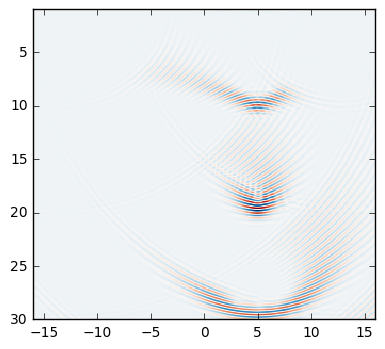

In [546]:
plt.imshow(np.sum(np.real(pr[:]),axis=0).T, extent=imgBoundsT, cmap=plt.cm.RdBu )